<a href="https://colab.research.google.com/github/manishiitg/ML_Experiments/blob/master/autoencoder/VAE_DFC_Experiment_with_Face_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE DEC Autoencoder Feed Forward Network

VAE  DEC Auto encoder on celeba data set 


In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json



-rw-r--r-- 1 root root 66 Nov 16 02:30 kaggle.json


In [0]:
!mkdir vae-dfc
!mkdir vae-dfc/models

mkdir: cannot create directory ‘vae-dfc’: File exists
mkdir: cannot create directory ‘vae-dfc/models’: File exists


In [0]:
# !kaggle datasets download -d ashishpatel26/indian-movie-face-database-imfdb
datasetname = "celeba-dataset"
!kaggle datasets download -d jessicali9530/celeba-dataset

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import zipfile

with zipfile.ZipFile("./" + datasetname  + ".zip","r") as zip_ref:
  zip_ref.extractall(datasetname)

Above, download data set from kaggle. 

In [0]:
import os
root = './' + datasetname + '/img_align_celeba/img_align_celeba'
img_list = os.listdir(root)
print(img_list[:10])
print(len(img_list))

['089999.jpg', '073820.jpg', '171662.jpg', '19416.jpg', '039538.jpg', '082875.jpg', '105134.jpg', '072589.jpg', '044720.jpg', '113262.jpg']
222507


Just to see if images exists 

In [0]:
import torch
import torch.nn as nn
import torchvision  
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import cv2


import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
!kaggle datasets download -d ashishpatel26/indian-movie-face-database-imfdb
datasetname2 = "indian-movie-face-database-imfdb"

import zipfile

with zipfile.ZipFile("./" + datasetname2  + ".zip","r") as zip_ref:
  zip_ref.extractall(datasetname2)



indian-movie-face-database-imfdb.zip: Skipping, found more recently modified local copy (use --force to force download)
19906


In [0]:
img_list = os.listdir("celeba-dataset/img_align_celeba/img_align_celeba/")
print(len(img_list))

img_list = os.listdir("indian-movie-face-database-imfdb/Train/Train")
print(len(img_list))

import shutil
import os

files = os.listdir("indian-movie-face-database-imfdb/Train/Train")

for f in files:
  shutil.copy("./indian-movie-face-database-imfdb/Train/Train/"+f, "./celeba-dataset/img_align_celeba/img_align_celeba/")
  pass
  
# !cp -r "indian-movie-face-database-imfdb/Train/Train" "celeba-dataset/img_align_celeba/img_align_celeba"

img_list = os.listdir("celeba-dataset/img_align_celeba/img_align_celeba/")
print(len(img_list))



202601
19906
222507


In [0]:
import PIL.Image as Image
# from imgaug import augmenters as iaa

# class ImgAugTransform:
#   def __init__(self):
#     self.aug = iaa.Sequential([
#         iaa.Fliplr(0.5),
#         iaa.Sometimes(0.4,\
#             iaa.ContrastNormalization((0.8, 1.2), per_channel=0.5)),
#         iaa.Sometimes(0.4,\
#             iaa.GaussianBlur(sigma=(0, 0.2))),
#     ])

# transform = transforms.Compose(
#       [
#        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#        ImgAugTransform(),
#        transforms.Resize((64, 64)),
#        transforms.ToTensor(),
#       ]
# )

image_size = 128


# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.ToPILImage(),
#      transforms.Resize(size=(image_size, image_size), interpolation=Image.BICUBIC),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])


# transform = transforms.ToTensor()

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    # torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    # torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomRotation(20, resample=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
# # 
# transforms.Normalize(mean=(0.485, 0.456, 0.406),
#                          std=(0.229, 0.224, 0.225))

batch_size = 128
celeba_data = datasets.ImageFolder('./' + datasetname, transform=transform)
# print(celeba_data)
dataset_len = 150000
# data_loader = DataLoader(celeba_data,batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(list(range(0, dataset_len))))
data_loader = DataLoader(celeba_data,batch_size=batch_size)
dataset_len = len(data_loader.dataset)

In [0]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

indian_data_set = datasets.ImageFolder('./' + datasetname2, transform=transform)
indian_data_loader = DataLoader(indian_data_set,batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


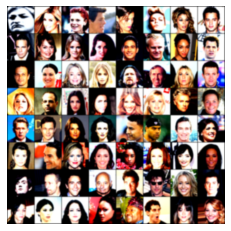

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


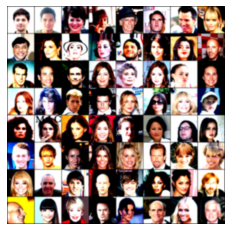

In [0]:
def show(img,renorm=False,nrow=8,interpolation='bicubic', save_image = False, filename="-"):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

  if save_image:
    torchvision.utils.save_image(img, filename ,nrow=nrow)

batch, _ = next(iter(data_loader))
show(batch[0:64], renorm = True, nrow=8, save_image=True, filename="./vae-dfc/image_preview.png")
show(batch[64:128], renorm = True, nrow=8)

Previewing the data 

In [0]:
class VAE(nn.Module):
    def __init__(self, nc, ngf, ndf, latent_variable_size):
        super(VAE, self).__init__()

        self.nc = nc
        self.ngf = ngf
        self.ndf = ndf
        self.latent_variable_size = latent_variable_size

        # encoder
        self.e1 = nn.Conv2d(nc, ndf, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(ndf)

        self.e2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(ndf*2)

        self.e3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(ndf*4)

        self.e4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(ndf*8)

        self.e5 = nn.Conv2d(ndf*8, ndf*8, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(ndf*8)

        self.fc1 = nn.Linear(ndf*8*4*4, latent_variable_size)
        self.fc2 = nn.Linear(ndf*8*4*4, latent_variable_size)

        # decoder
        self.d1 = nn.Linear(latent_variable_size, ngf*8*2*4*4)

        self.up1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd1 = nn.ReplicationPad2d(1)
        self.d2 = nn.Conv2d(ngf*8*2, ngf*8, 3, 1)
        self.bn6 = nn.BatchNorm2d(ngf*8, 1.e-3)

        self.up2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd2 = nn.ReplicationPad2d(1)
        self.d3 = nn.Conv2d(ngf*8, ngf*4, 3, 1)
        self.bn7 = nn.BatchNorm2d(ngf*4, 1.e-3)

        self.up3 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd3 = nn.ReplicationPad2d(1)
        self.d4 = nn.Conv2d(ngf*4, ngf*2, 3, 1)
        self.bn8 = nn.BatchNorm2d(ngf*2, 1.e-3)

        self.up4 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd4 = nn.ReplicationPad2d(1)
        self.d5 = nn.Conv2d(ngf*2, ngf, 3, 1)
        self.bn9 = nn.BatchNorm2d(ngf, 1.e-3)

        self.up5 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd5 = nn.ReplicationPad2d(1)
        self.d6 = nn.Conv2d(ngf, nc, 3, 1)

        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.leakyrelu(self.bn1(self.e1(x)))
        h2 = self.leakyrelu(self.bn2(self.e2(h1)))
        h3 = self.leakyrelu(self.bn3(self.e3(h2)))
        h4 = self.leakyrelu(self.bn4(self.e4(h3)))
        h5 = self.leakyrelu(self.bn5(self.e5(h4)))
        h5 = h5.view(-1, self.ndf*8*4*4)

        return self.fc1(h5), self.fc2(h5)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().to(device)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def decode(self, z):
        h1 = self.relu(self.d1(z))
        h1 = h1.view(-1, self.ngf*8*2, 4, 4)
        h2 = self.leakyrelu(self.bn6(self.d2(self.pd1(self.up1(h1)))))
        h3 = self.leakyrelu(self.bn7(self.d3(self.pd2(self.up2(h2)))))
        h4 = self.leakyrelu(self.bn8(self.d4(self.pd3(self.up3(h3)))))
        h5 = self.leakyrelu(self.bn9(self.d5(self.pd4(self.up4(h4)))))

        return self.sigmoid(self.d6(self.pd5(self.up5(h5))))

    def get_latent_var(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, mu, logvar

batch, _ = next(iter(data_loader))
img = batch[1]

channels = img.size(0)
w, h = img.size(1) , img.size(2) 

nc = channels
ndf = w
ngf = h

model = VAE(nc=nc, ngf=ngf, ndf=ndf, latent_variable_size = 500).to(device)

print(f"{nc}: no of channels in image")
print(f"{ndf}: width of image")
print(f"{ngf} height of image")


3: no of channels in image
128: width of image
128 height of image


In [0]:
import torchvision.models as models

layer_names = ['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
               'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
               'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
               'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
               'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5']
vae123_layers = ['relu1_1', 'relu2_1', 'relu3_1']
vae345_layers = ['relu3_1', 'relu4_1', 'relu5_1']

class _VGG(nn.Module):
    def __init__(self, model):
        super(_VGG, self).__init__()

        # Load pretrained model
        features = models.vgg19(pretrained=True).features

        # Rename layers
        self.features = nn.Sequential()
        for i, module in enumerate(features):
            name = layer_names[i]
            self.features.add_module(name, module)

        # Disable autograd
        for param in self.features.parameters():
            param.requires_grad = False
          
        # Content layers
        if model == "vae-123":
            self.content_layers = vae123_layers
        elif model == "vae-345":
            self.content_layers = vae345_layers
        

    def forward(self, inputs):
        batch_size = inputs.size(0)
        all_outputs = []
        output = inputs
        for name, module in self.features.named_children():
            output = module(output)
            if name in self.content_layers:
                all_outputs.append(output.view(batch_size, -1))
        return all_outputs

class KLDLoss(nn.Module):
    def __init__(self, reduction='sum'):
        super(KLDLoss, self).__init__()
        self.reduction = reduction

    def forward(self, mean, logvar):
        # KLD loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), 1)
        # Size average
        if self.reduction == 'mean':
            kld_loss = torch.mean(kld_loss)
        elif self.reduction == 'sum':
            kld_loss = torch.sum(kld_loss)
        return kld_loss

class FLPLoss(nn.Module):
    def __init__(self, model, device, reduction='sum'):
        super(FLPLoss, self).__init__()
        # self.criterion = nn.BCELoss(reduction='sum')
        self.criterion = nn.MSELoss(reduction=reduction)
        self.pretrained = _VGG(model).to(device)
    
    def forward(self, x, recon_x):
        x_f = self.pretrained(x)
        recon_f = self.pretrained(recon_x)
        return self._fpl(recon_f, x_f)

    def _fpl(self, recon_f, x_f):
        fpl = 0
        for _r, _x in zip(recon_f, x_f):
            fpl += self.criterion(_r, _x)
        return fpl


In [0]:

model_type = "vae-345"

#trying out pre-trained model
descriptor = _VGG("vae-345").to(device)
for batch_idx, (data, _) in enumerate(data_loader):
  data = data.to(device)
  outputs = descriptor(data)
  # print(outputs)
  break

# Reconstruction loss
if model_type == "pvae":
    reconst_criterion = nn.MSELoss(reduction='sum')
elif model_type == "vae-123" or model_type == "vae-345":
    reconst_criterion = FLPLoss(model_type, device, reduction='sum')
# KLD loss
kld_criterion = KLDLoss(reduction='sum')

# Solver
optimizer = optim.Adam(model.parameters(), .0001)
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)


In [0]:

alpha = 1
beta = 1

def train(epoch, train_data_loader):
    model.train()
    train_loss = 0
    count_data = 0
    batch_count_data = 0
    for batch_idx, (data, _) in enumerate(train_data_loader):
        # print(batch_idx)
        count_data += len(data)
        batch_count_data += len(data)
        images = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(images)
        # loss = loss_fn(recon_batch, images, mu, log_var)

        # print(images.shape, "input images")
        # print(recon_batch.shape,"encoded images")

        reconst_loss = reconst_criterion(images, recon_batch)
        kld_loss = kld_criterion(mu, log_var)

        loss = alpha * kld_loss + beta * reconst_loss
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), dataset_len,
                100. * batch_idx / len(train_data_loader), loss.item() / batch_count_data))
            batch_count_data = 0

    # show(images.cpu().detach(), renorm = True, nrow=8, save_image=True, filename=f"vae-dfc-train.png")
    show(recon_batch.cpu().detach(), renorm = True, nrow=8, save_image=True, filename=f"./vae-dfc/vae-dfc-train-enc-{epoch+1}.png")
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / count_data))
    return (train_loss / count_data)

# train(1, indian_data_loader)

Setting up the model

In [0]:
# for i in range(10):
#   train(i)


In [0]:
# torch.save(model.state_dict(), './vae-dfc/modelsceleba_100000_dataset_dfc_vae_Epoch_{}_.pth'.format(150))  

In [0]:
# !cp celeba_100000_dataset_dfc_vae_Epoch_150_.pth "drive/My Drive/Colab Notebooks/"

In [0]:
# model.load_state_dict(torch.load("./vae-dfc/models/celeba_100000_dataset_dfc_vae_Epoch_150_.pth",map_location=torch.device('cpu')))

Last checkpoint:  vae-dfc/models/vae-dfc-celeba-Epoch_200_Train_loss_2455203.8876_Test_loss_0.0000.pth
Train Epoch: 201 [0/249047 (0%)]	Loss: 2968066.000000
Train Epoch: 201 [1280/249047 (1%)]	Loss: 249355.475000
Train Epoch: 201 [2560/249047 (1%)]	Loss: 244364.675000
Train Epoch: 201 [3840/249047 (2%)]	Loss: 243245.600000
Train Epoch: 201 [5120/249047 (2%)]	Loss: 226782.425000
Train Epoch: 201 [6400/249047 (3%)]	Loss: 223489.325000
Train Epoch: 201 [7680/249047 (3%)]	Loss: 220387.200000
Train Epoch: 201 [8960/249047 (4%)]	Loss: 228153.800000
Train Epoch: 201 [10240/249047 (4%)]	Loss: 223923.175000
Train Epoch: 201 [11520/249047 (5%)]	Loss: 225629.975000
Train Epoch: 201 [12800/249047 (5%)]	Loss: 227373.425000
Train Epoch: 201 [14080/249047 (6%)]	Loss: 233208.525000
Train Epoch: 201 [15360/249047 (6%)]	Loss: 235344.225000
Train Epoch: 201 [16640/249047 (7%)]	Loss: 233008.900000
Train Epoch: 201 [17920/249047 (7%)]	Loss: 222259.900000
Train Epoch: 201 [19200/249047 (8%)]	Loss: 228547.07

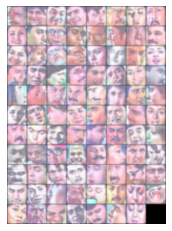

====> Epoch: 201 Average loss: 1945425.6652
Train Epoch: 202 [0/249047 (0%)]	Loss: 2917639.500000
Train Epoch: 202 [1280/249047 (1%)]	Loss: 239473.150000
Train Epoch: 202 [2560/249047 (1%)]	Loss: 233324.225000
Train Epoch: 202 [3840/249047 (2%)]	Loss: 231318.025000
Train Epoch: 202 [5120/249047 (2%)]	Loss: 215110.000000
Train Epoch: 202 [6400/249047 (3%)]	Loss: 212047.575000
Train Epoch: 202 [7680/249047 (3%)]	Loss: 209305.425000
Train Epoch: 202 [8960/249047 (4%)]	Loss: 216335.875000
Train Epoch: 202 [10240/249047 (4%)]	Loss: 212782.250000
Train Epoch: 202 [11520/249047 (5%)]	Loss: 214545.550000
Train Epoch: 202 [12800/249047 (5%)]	Loss: 216479.350000
Train Epoch: 202 [14080/249047 (6%)]	Loss: 222252.400000
Train Epoch: 202 [15360/249047 (6%)]	Loss: 223929.925000
Train Epoch: 202 [16640/249047 (7%)]	Loss: 222127.775000
Train Epoch: 202 [17920/249047 (7%)]	Loss: 212195.425000
Train Epoch: 202 [19200/249047 (8%)]	Loss: 217631.375000
Train Epoch: 202 [20480/249047 (8%)]	Loss: 218551.5750

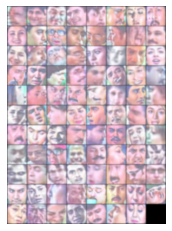

====> Epoch: 202 Average loss: 1881589.5997
Train Epoch: 203 [0/249047 (0%)]	Loss: 2907348.000000
Train Epoch: 203 [1280/249047 (1%)]	Loss: 238126.700000
Train Epoch: 203 [2560/249047 (1%)]	Loss: 232728.375000
Train Epoch: 203 [3840/249047 (2%)]	Loss: 230563.300000
Train Epoch: 203 [5120/249047 (2%)]	Loss: 213461.375000
Train Epoch: 203 [6400/249047 (3%)]	Loss: 210246.625000
Train Epoch: 203 [7680/249047 (3%)]	Loss: 207581.587500
Train Epoch: 203 [8960/249047 (4%)]	Loss: 213880.700000
Train Epoch: 203 [10240/249047 (4%)]	Loss: 210665.700000
Train Epoch: 203 [11520/249047 (5%)]	Loss: 211875.075000
Train Epoch: 203 [12800/249047 (5%)]	Loss: 214056.850000
Train Epoch: 203 [14080/249047 (6%)]	Loss: 219668.950000
Train Epoch: 203 [15360/249047 (6%)]	Loss: 220875.925000
Train Epoch: 203 [16640/249047 (7%)]	Loss: 218903.875000
Train Epoch: 203 [17920/249047 (7%)]	Loss: 209536.400000
Train Epoch: 203 [19200/249047 (8%)]	Loss: 214552.325000
Train Epoch: 203 [20480/249047 (8%)]	Loss: 215130.0250

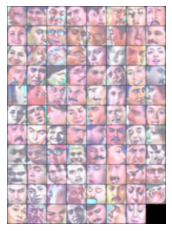

====> Epoch: 203 Average loss: 1842972.4828
Train Epoch: 204 [0/249047 (0%)]	Loss: 2696750.250000
Train Epoch: 204 [1280/249047 (1%)]	Loss: 225870.325000
Train Epoch: 204 [2560/249047 (1%)]	Loss: 222896.550000
Train Epoch: 204 [3840/249047 (2%)]	Loss: 221594.325000
Train Epoch: 204 [5120/249047 (2%)]	Loss: 206243.775000
Train Epoch: 204 [6400/249047 (3%)]	Loss: 203535.912500
Train Epoch: 204 [7680/249047 (3%)]	Loss: 200915.662500
Train Epoch: 204 [8960/249047 (4%)]	Loss: 207470.612500
Train Epoch: 204 [10240/249047 (4%)]	Loss: 204893.537500
Train Epoch: 204 [11520/249047 (5%)]	Loss: 206335.650000
Train Epoch: 204 [12800/249047 (5%)]	Loss: 208328.187500
Train Epoch: 204 [14080/249047 (6%)]	Loss: 214034.100000
Train Epoch: 204 [15360/249047 (6%)]	Loss: 215225.350000
Train Epoch: 204 [16640/249047 (7%)]	Loss: 213256.100000
Train Epoch: 204 [17920/249047 (7%)]	Loss: 204204.337500
Train Epoch: 204 [19200/249047 (8%)]	Loss: 209263.275000
Train Epoch: 204 [20480/249047 (8%)]	Loss: 210072.7500

KeyboardInterrupt: ignored

In [0]:
from pathlib import Path

def load_last_model():
    models = Path('./vae-dfc/models/').rglob('*.pth')
    
    model_ids = [(int((f.as_posix()).split('_')[1]), f.as_posix()) for f in models]
    start_epoch, last_cp = max(model_ids, key=lambda item:item[0])
    print('Last checkpoint: ', last_cp)
    model.load_state_dict(torch.load(last_cp))
    return start_epoch, last_cp

epochs = 10
def resume_training():
    start_epoch, _ = load_last_model()

    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
        train_loss = train(epoch, data_loader)
        # test_loss = test(epoch)
        test_loss = 0
        # !rm -rf "./var-dfc/models/*"
        torch.save(model.state_dict(), './vae-dfc/models/vae-dfc-celeba-Epoch_{}_Train_loss_{:.4f}_Test_loss_{:.4f}.pth'.format(epoch, train_loss, test_loss))
        # !cp -rf "./vae-dfc" "drive/My Drive/Colab Notebooks/"

resume_training()

# load_last_model()
# epoch = 150
# train_loss = 2080106
# test_loss = 0
# torch.save(model.state_dict(), './vae-dfc/models/Epoch_{}_Train_loss_{:.4f}_Test_loss_{:.4f}.pth'.format(epoch, train_loss, test_loss))

See the model output that compare the original image with generated image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


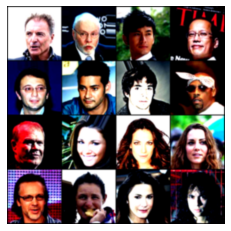

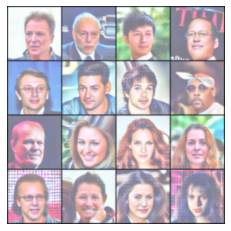

In [0]:
from torch.utils.data import RandomSampler
from torchvision.utils import save_image
import matplotlib.image as mpimg

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    # transforms.RandomRotation(45),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

batch_size = 16
celeba_data = datasets.ImageFolder('./' + datasetname, transform=transform)
dataset_len = 100
test_loader = DataLoader(celeba_data,batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(list(range(100000, 200000))))


with torch.no_grad():
  # test_loader = DataLoader(celeba_data,batch_size=16, shuffle=True)
  itr = iter(test_loader)
  # next(itr)
  batch, _ = next(itr)
  batch = batch.to(device)
  model.eval()
  recon_batch, _, _  = model(batch)

  show(batch.cpu(), renorm = True, nrow=4)
  show(recon_batch.cpu(), renorm = True, nrow=4, save_image=True, filename="./vae-dfc/final_output.png")


# epoch = 1
# n = 5

# comparison = torch.cat([batch[:n],recon_batch[:n]])

# save_image(comparison.cpu(),'reconstruction_ecommerce' + str(epoch) + '.png', nrow=n)
                
# plt.imshow(mpimg.imread('reconstruction_ecommerce' + str(epoch) + '.png'), aspect=True)


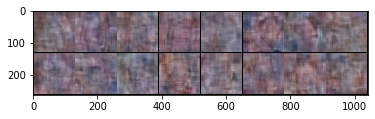

In [0]:
with torch.no_grad():
    epoch = "random_image_generator"
    sample = torch.randn(16, 500).to(device)
    sample = model.decode(sample).cpu()
    # print(sample.shape)
    sample = sample.view(-1, nc, ndf, ngf)
    
    save_image(sample,
                'sample_' + str(epoch) + '.png')
    plt.imshow(mpimg.imread('sample_' + str(epoch) + '.png'))

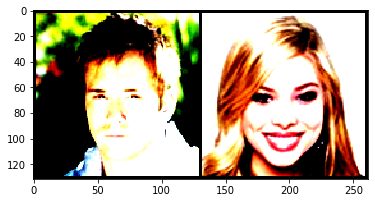

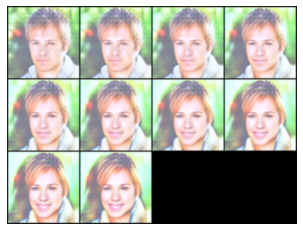

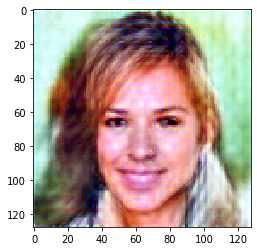

In [0]:
import numpy as np
import random 


def between(x_from, x_to):
  t_from= model.get_latent_var(x_from)
  t_to = model.get_latent_var(x_to)

  middle = torch.lerp(t_from, t_to, .5)

  return model.decode(middle)

def linear_interpolation2(model, x_from, x_to, steps):
    n = steps

    t_from = model.get_latent_var(x_from)
    t_to = model.get_latent_var(x_to)

    t_from = t_from.cpu().detach().numpy()
    t_to = t_to.cpu().detach().numpy()

    diff = t_to - t_from
    inter = np.zeros((n, t_from.shape[1]))
    for i in range(n):
        inter[i] = t_from + np.linspace(0,1,steps)[i] * t_to

    inter = torch.tensor(inter).float().to(device)

    return model.decode(inter)


def linear_interpolation(model, x_from, x_to, steps):

    t_from = model.get_latent_var(x_from)
    t_to = model.get_latent_var(x_to)

    diff = t_to - t_from
    n = 11
    inter = torch.zeros(n, t_from.shape[1])
    for j, alpha in enumerate(np.arange(0.0, 1.1, 0.1)):
        z_inp = alpha * (t_from - t_to) + t_from
        inter[j] = z_inp

    inter = torch.tensor(inter).float().to(device)

    return model.decode(inter)

def plot_linear_interpolations(x_from, x_to, steps=10):
    # batch = linear_interpolation(model, x_from, x_to, steps)
    # batch = batch.view(-1, nc, ndf, ngf)
    # show(batch.cpu(), renorm = True, nrow=4)

    batch = linear_interpolation2(model, x_from, x_to, steps)
    batch = batch.view(-1, nc, ndf, ngf)
    show(batch.cpu(), renorm = True, nrow=4, save_image=True, filename='plot_interpolation.png')

def show_single_image(img, name):
  save_image(img,
                'sample_' + name + '.png')
  plt.imshow(mpimg.imread('sample_' + name + '.png'))

with torch.no_grad():
  img1, _ = data_loader.dataset[random.randint(0, 200000)]
  img2, _  = data_loader.dataset[random.randint(0, 200000)]
  img1 = img1.to(device)
  img2 = img2.to(device)
  img1.unsqueeze_(0)

  img2.unsqueeze_(0)

  show_single_image(torch.cat((img1, img2)), "img1")
  
  plot_linear_interpolations(img1, img2)


img3 = between(img1, img2)
show_single_image(img3, "img3")


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# !mv "drive/My Drive/Colab Notebooks/celeba_100000_dataset_dfc_vae_Epoch_150_.pth" "drive/My Drive/Colab Notebooks/celeba_150_dataset_dfc_vae.pth"

# !cp "drive/My Drive/Colab Notebooks/celeba_150_dataset_dfc_vae.pth" "./vae-dfc/models/."

# !mkdir "drive/My Drive/Colab Notebooks/vae-dfc/models"
!cp -rf "./vae-dfc" "drive/My Drive/Colab Notebooks/"

In [0]:
!cp -rf "drive/My Drive/Colab Notebooks/vae-dfc" "./vae-dfc" 

In [0]:
# !rm -rf ./vae-dfc

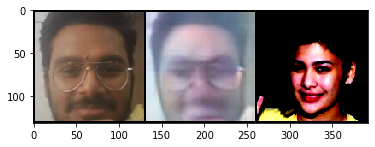

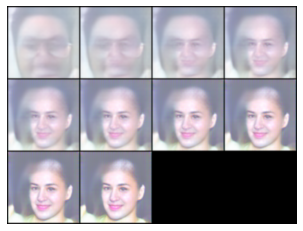

In [0]:
# from google.colab import files
# uploaded = files.upload()


import random
# import os
# import shutil
# try:
#     os.mkdir("testing/test")
# except OSError:
#   pass

# try:
#     os.mkdir("vae-dfc/testing-output")
# except OSError:
#   pass

# for k, v in uploaded.items():
#     shutil.move(k, "testing/test" + k)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[.5]*3, std=[.5]*3)
    ])

batch_size = 16
celeba_data = datasets.ImageFolder('./testing' , transform=transform)
test_loader = DataLoader(celeba_data,batch_size=batch_size)


with torch.no_grad():
  # test_loader = DataLoader(celeba_data,batch_size=16, shuffle=True)
  # itr = iter(test_loader)
  # next(itr)
  # batch, _ = next(itr)
  # batch = batch.to(device)
  model.eval()
  # recon_batch, _, _  = model(batch)

  for i in range(len(test_loader.dataset)):
    my_img,_ = test_loader.dataset[i]
    img1, _ = data_loader.dataset[random.randint(0, 200000)]

    my_img = my_img.to(device)
    img1 = img1.to(device)
    my_img.unsqueeze_(0)
    img1.unsqueeze_(0)
    

    org, _ , _  = model(my_img)

    # show_single_image(org, "org")


    show_single_image(torch.cat((my_img, org , img1)), "img1")
    
    plot_linear_interpolations(my_img,img1)

    # img3 = between(my_img, img1)
    # show_single_image(img3, "img3")
